# IoT-LAB and Grid'5000: Simple example application

This tutorial shows how to deploy and run an application which uses resources from both IoT-LAB and Grid'5000 testbeds.

![title](simple_example_topology.png)

The application is quite simple, an agent that collects data from sensors (e.g. temperature) and do some processing (matrix multiplication).

The test contains 3 main elements:
- **Sensors**: a contiki image is deployed in the M3 sensors of FIT/IoT-LAB testbed. Note that an M3 node is used as border router to enable connection to the outside world (through the IoT-LAB frontend).
- **Compute** nodes: on these nodes, the user's application is deployed along with the Telegraf agent which monitors the resource consumption. They can run in both A8 and Grid'5000 nodes.
- **Control** node: one node in Grid'5000 is used to deploy the monitoring agents. These agents collect and store the metrics generated by the Telegraf running on compute nodes.

All communication is done through global IPv6 addresses in both testbeds. Due to security restriction in Grid'5000, IPv6 communications must flow from Grid'5000 to FIT/IoT-LAB (the opposite direction is filtered out by Grid'5000). 

## Initialization

Let's start by loading the libraries used in our test.

In [1]:
from enoslib import *

import logging
import sys

Note: Openstack clients not installed


Configuring logging: save DEBUG to a file and INFO to stdout

In [2]:
log = logging.getLogger()
log.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler("debug.log", 'a')
fileHandler.setLevel(logging.DEBUG)
fileHandler.setFormatter(formatter)
log.addHandler(fileHandler)

cformat = logging.Formatter("[%(levelname)8s] : %(message)s")
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(cformat)
consoleHandler.setLevel(logging.INFO)
log.addHandler(consoleHandler)

**Describing the resources** used in both testbeds.

In [3]:
dev=True
iotlab_dict_dev = {
    "walltime": "03:00",
    "resources":
    {"machines": [
        { "roles":["a8"], "hostname": ["a8-33.grenoble.iot-lab.info", "a8-34.grenoble.iot-lab.info"]},
        { "roles":["sensor"], "hostname": ["m3-49.grenoble.iot-lab.info"], "image": "m3_images/er-example-server.iotlab-m3"},
        { "roles":["border_router"], "hostname": ["m3-51.grenoble.iot-lab.info"], "image": "m3_images/border-router.iotlab-m3"},
    ]}
}
iotlab_dict = {
    "walltime": "03:00",
    "resources":
    {"machines": [
        {
            "roles": ["sensor"],
            "archi": "m3:at86rf231",
            "site": "grenoble",
            "number": 9,
            "image": "m3_images/er-example-server.iotlab-m3",
        },
        {
            "roles": ["border_router"],
            "archi": "m3:at86rf231",
            "site": "grenoble",
            "number": 1,
            "image": "m3_images/border-router.iotlab-m3",
        },        
        {
            "roles": ["a8"],
            "archi": "a8:at86rf231",
            "site": "grenoble",
            "number": 5,
        },
    ]}
}
if dev:
    iotlab_conf = IotlabConf.from_dictionary(iotlab_dict_dev)
else:
    iotlab_conf = IotlabConf.from_dictionary(iotlab_dict)
iotlab_provider = Iotlab(iotlab_conf)

{
    "job_name": "EnOSlib",
    "walltime": "03:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "a8"
                ],
                "hostname": [
                    "a8-33.grenoble.iot-lab.info",
                    "a8-34.grenoble.iot-lab.info"
                ]
            },
            {
                "roles": [
                    "sensor"
                ],
                "image": "m3_images/er-example-server.iotlab-m3",
                "hostname": [
                    "m3-49.grenoble.iot-lab.info"
                ]
            },
            {
                "roles": [
                    "border_router"
                ],
                "image": "m3_images/border-router.iotlab-m3",
                "hostname": [
                    "m3-51.grenoble.iot-lab.info"
                ]
            }
        ],
        "networks": []
    }
}
{
    "job_name": "EnOSlib",
    "walltime": "03:00",
    "resources": {
   

In [4]:
g5k_dict = {
    "job_type": "allow_classic_ssh",
    "walltime": "03:00:00",
    "resources": {
        "machines": [
            {
                "roles": ["control"],
                "cluster": "parasilo",
                "nodes": 1,
                "primary_network": "default",
            },
            {
                "roles": ["compute"],
                "cluster": "parasilo",
                "nodes": 1,
                "primary_network": "default",
            },
        ],
        "networks": [
            {"id": "default", "type": "prod", "roles": ["prod"], "site": "rennes"}
        ],
    },
}
g5k_conf = G5kConf.from_dictionnary(g5k_dict)
g5k_provider = G5k(g5k_conf)

{'roles': ['control'], 'primary_network': 'default', 'secondary_networks': [], 'cluster': 'parasilo', 'nodes': 1}
{'roles': ['compute'], 'primary_network': 'default', 'secondary_networks': [], 'cluster': 'parasilo', 'nodes': 1}
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "EnOSlib",
    "job_type": "allow_classic_ssh",
    "key": "/home/donassolo/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "03:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "control"
                ],
                "primary_network": "default",
                "secondary_networks": [],
                "cluster": "parasilo",
                "nodes": 1
            },
            {
                "roles": [
                    "compute"
                ],
                "primary_network": "default",
                "secondary_networks": [],
                "cluster": "parasilo",
          

Reserving the resources in both testbed.

In [5]:
iotlab_roles, iotlab_networks = iotlab_provider.init()
g5k_roles, g5k_networks = g5k_provider.init()

[    INFO] : Submitting FIT/IoT-LAB: job id: EnOSlib, duration: 03:00, resources: [{'type': 'physical', 'nodes': ['a8-33.grenoble.iot-lab.info', 'a8-34.grenoble.iot-lab.info'], 'firmware': None, 'profile': None, 'associations': {}}, {'type': 'physical', 'nodes': ['m3-49.grenoble.iot-lab.info'], 'firmware': None, 'profile': None, 'associations': {}}, {'type': 'physical', 'nodes': ['m3-51.grenoble.iot-lab.info'], 'firmware': None, 'profile': None, 'associations': {}}]
[    INFO] : Job submitted: 246803
[    INFO] : Waiting for job id (246803) to be in running state
[    INFO] : Job id (246803) is running
[    INFO] : Finished reserving nodes: hosts [<IotlabHost(roles=['a8'], address=a8-33.grenoble.iot-lab.info, ssh_address=node-a8-33.grenoble.iot-lab.info, site=grenoble, uid=9661)>, <IotlabHost(roles=['a8'], address=a8-34.grenoble.iot-lab.info, ssh_address=node-a8-34.grenoble.iot-lab.info, site=grenoble, uid=c162)>], sensors [<IotlabSensor(roles=['sensor'], address=m3-49.grenoble.iot-lab

/home/donassolo/enoslib_env/lib/python3.8/site-packages/grid5000/__init__.py:111: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  conf = yaml.load(f)


[    INFO] : Reloading EnOSlib from luxembourg
[    INFO] : Reloading EnOSlib from lyon
[    INFO] : Reloading EnOSlib from nancy
[    INFO] : Reloading EnOSlib from nantes
[    INFO] : Reloading EnOSlib from rennes
[    INFO] : Reloading EnOSlib from sophia
[    INFO] : Submitting {'name': 'EnOSlib', 'types': ['allow_classic_ssh'], 'resources': "{cluster='parasilo'}/nodes=1+{cluster='parasilo'}/nodes=1,walltime=03:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes
[ WARNING] : Retrying (Retry(total=4, connect=5, read=4, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /stable/sites/rennes/jobs/1430467
[ WARNING] : Retrying (Retry(total=4, connect=5, read=4, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /stable/sites/rennes/jobs/1430467
[ 

## IoT-LAB setup

**Bridging M3 wireless network to internet**.
Follow the steps in tutorial: https://www.iot-lab.info/legacy/tutorials/contiki-coap-m3/index.html

Run the tunslip6 in the frontend node. We need to select one available network to run tunslip.

In [6]:
iotlab_ipv6_net="2001:660:5307:314e::"

import iotlabcli.auth
iotlab_user, _ = iotlabcli.auth.get_user_credentials()

iotlab_frontend_conf = (
    StaticConf()
    .add_machine(
        roles=["frontend"],
        address="grenoble.iot-lab.info",
        alias="grenoble",
        user=iotlab_user
    )
    .finalize()
)

frontend_provider = Static(iotlab_frontend_conf)
frontend_roles, _ = frontend_provider.init()

tun_cmd = "sudo tunslip6.py -v4 -L -a %s -p 20000 %s/64 > tunslip.output 2>&1" % (iotlab_roles["border_router"][0].alias, iotlab_ipv6_net)
result=run_command(tun_cmd, roles=frontend_roles, asynch=3600, poll=0)

[WARNING]: No inventory was parsed, only implicit localhost is available


{
    "resources": {
        "machines": [
            {
                "address": "grenoble.iot-lab.info",
                "roles": [
                    "frontend"
                ],
                "alias": "grenoble",
                "user": "donassol"
            }
        ],
        "networks": []
    }
}
None

PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
 [started TASK: Gathering Facts on grenoble]


[WARNING]: Platform linux on host grenoble is using the discovered Python
interpreter at /usr/bin/python, but future installation of another Python
interpreter could change this. See https://docs.ansible.com/ansible/2.9/referen
ce_appendices/interpreter_discovery.html for more information.


ok: [grenoble]

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on grenoble]
changed: [grenoble]


Reseting border router node

In [7]:
iotlab_roles["border_router"][0].reset()

[    INFO] : Executing command (reset) on nodes (['m3-51.grenoble.iot-lab.info'])


Looking output of tunslip command to check status and get border router IPv6 address.

In [8]:
result = run_command("cat tunslip.output", roles=frontend_roles)
print(result['ok'])

import re
out = result['ok']['grenoble']['stdout']
print(out)
match = re.search(rf'Server IPv6 addresses:\n.+(2001[0-9a-fA-F:]+)\n', out, re.MULTILINE|re.DOTALL)
br_ipv6 = match.groups()[0]
print("Border Router IPv6 address from tunslip output: %s" % br_ipv6)

None

PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
 [started TASK: Gathering Facts on grenoble]
ok: [grenoble]

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on grenoble]
changed: [grenoble]
{'grenoble': {'stdout': "slip connected to ``172.16.10.51:20000''\n\n14:40:32 opened tun device ``/dev/tun0''\n0000.001 ifconfig tun0 inet `hostname` mtu 1500 up\n0000.017 ifconfig tun0 add 2001:660:5307:314e::/64\n0000.024 ifconfig tun0 add fe80::660:5307:314e:0/64\n0000.032 ifconfig tun0\n\ntun0: flags=4305<UP,POINTOPOINT,RUNNING,NOARP,MULTICAST>  mtu 1500\n        inet 192.168.1.5  netmask 255.255.255.255  destination 192.168.1.5\n        inet6 2001:660:5307:314e::  prefixlen 64  scopeid 0x0<global>\n        inet6 fe80::660:5307:314e:0  prefixlen 64  scopeid 0x20<link>\n        inet6 fe80::8bc:93ae:2da0:ba4d

## Grid'5000 setup

Enabling IPv6 on Grid'5000.

In [9]:
result=run_command("dhclient -6 br0", roles=g5k_roles)

None

PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
 [started TASK: Gathering Facts on parasilo-14.rennes.grid5000.fr]
 [started TASK: Gathering Facts on parasilo-15.rennes.grid5000.fr]


[WARNING]: Platform linux on host parasilo-14.rennes.grid5000.fr is using the
discovered Python interpreter at /usr/bin/python, but future installation of
another Python interpreter could change this. See https://docs.ansible.com/ansi
ble/2.9/reference_appendices/interpreter_discovery.html for more information.


ok: [parasilo-14.rennes.grid5000.fr]


[WARNING]: Platform linux on host parasilo-15.rennes.grid5000.fr is using the
discovered Python interpreter at /usr/bin/python, but future installation of
another Python interpreter could change this. See https://docs.ansible.com/ansi
ble/2.9/reference_appendices/interpreter_discovery.html for more information.


ok: [parasilo-15.rennes.grid5000.fr]

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on parasilo-14.rennes.grid5000.fr]
 [started TASK: enoslib_adhoc_command on parasilo-15.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]
changed: [parasilo-14.rennes.grid5000.fr]


## Monitoring stack

Synchronize IPv6 addresses in host information

In [10]:
g5k_roles = sync_network_info(g5k_roles, g5k_networks)
iotlab_roles = sync_network_info(iotlab_roles, iotlab_networks)

[    INFO] : Running playbook /home/donassolo/cs2/enoslib_tests/simple_example/tmpu9skrrrz with vars:
{}

PLAY [all] *********************************************************************

TASK [hostname] ****************************************************************
changed: [parasilo-14.rennes.grid5000.fr]
changed: [parasilo-15.rennes.grid5000.fr]

PLAY RECAP *********************************************************************
parasilo-14.rennes.grid5000.fr : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
parasilo-15.rennes.grid5000.fr : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   

{'code': 0, 'result': [{'parasilo-14.rennes.grid5000.fr': {'ok': 1, 'failures': 0, 'unreachable': 0, 'changed': 1, 'skipped': 0, 'rescued': 0, 'ignored': 0}}, {'parasilo-15.rennes.grid5000.fr': {'ok': 1, 'failures': 0, 'unreachable': 0, 'changed': 1, 'skipped': 0, 'rescued': 0, 'ignored': 0}}], 'playbook': '/home/donas

[WARNING]: Platform linux on host node-a8-34.grenoble.iot-lab.info is using the
discovered Python interpreter at /usr/bin/python, but future installation of
another Python interpreter could change this. See https://docs.ansible.com/ansi
ble/2.9/reference_appendices/interpreter_discovery.html for more information.


ok: [node-a8-34.grenoble.iot-lab.info]


[WARNING]: Platform linux on host node-a8-33.grenoble.iot-lab.info is using the
discovered Python interpreter at /usr/bin/python, but future installation of
another Python interpreter could change this. See https://docs.ansible.com/ansi
ble/2.9/reference_appendices/interpreter_discovery.html for more information.


ok: [node-a8-33.grenoble.iot-lab.info]

TASK [setup] *******************************************************************
ok: [node-a8-34.grenoble.iot-lab.info]
ok: [node-a8-33.grenoble.iot-lab.info]

PLAY [Utils functions] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [node-a8-33.grenoble.iot-lab.info]
ok: [node-a8-34.grenoble.iot-lab.info]

TASK [utils : include] *********************************************************
included: /home/donassolo/enoslib/enoslib/ansible/roles/utils/tasks/check_network.yml for node-a8-33.grenoble.iot-lab.info, node-a8-34.grenoble.iot-lab.info

TASK [utils : Dump network information in a file] ******************************
changed: [node-a8-33.grenoble.iot-lab.info]

TASK [utils : Create the fake interfaces] **************************************
skipping: [node-a8-33.grenoble.iot-lab.info]
skipping: [node-a8-34.grenoble.iot-lab.info]

PLAY RECAP **********

**Install monitoring stack**

In [11]:
from ipaddress import IPv6Network
print("Install Grafana and Prometheus at: %s" % str(g5k_roles["control"]))
print("Install Telegraf at: %s" % str(g5k_roles["compute"]))
def get_nets(networks, net_type):
    """ Aux method to filter networs from roles """
    return [
        n for net_list in networks.values() for n in net_list
        if isinstance(n.network, net_type)
    ]

monitoring = TPGMonitoring(
        collector=g5k_roles["control"][0],
        agent=g5k_roles["compute"]+iotlab_roles["a8"],
        ui=g5k_roles["control"][0],
        networks=get_nets(g5k_networks, IPv6Network) + get_nets(iotlab_networks, IPv6Network)
)
monitoring.deploy()

Install Grafana and Prometheus at: [Host(address='parasilo-14.rennes.grid5000.fr', alias='parasilo-14.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, extra_devices={BridgeDevice(name='br0', addresses={IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd6Network object at 0x7f884921b5e0>, ip=IPv6Interface('2001:660:4406:700:2::e/128')), IPAddress(network=None, ip=IPv6Interface('fe80::eef4:bbff:fed1:590/64')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7f884921b4f0>, ip=IPv4Interface('172.16.97.14/20'))}, bridged=['eno1']), NetDevice(name='eno4', addresses=set()), NetDevice(name='eno1', addresses=set()), NetDevice(name='eno2', addresses=set()), NetDevice(name='eno3', addresses=set()), NetDevice(name='lo', addresses={IPAddress(network=None, ip=IPv4Interface('127.0.0.1/8')), IPAddress(network=None, ip=IPv6Interface('::1/128'))})})]
Install Telegraf at: [Host(address='parasilo-15.rennes.grid5000.fr', alias='parasilo-15.ren

[WARNING]: Could not match supplied host pattern, ignoring: influxdb



PLAY [Monitoring - InfluxDB collector] *****************************************
skipping: no hosts matched

PLAY [Monitoring - Prometheus collector] ***************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-14.rennes.grid5000.fr]

TASK [Install python3] *********************************************************
changed: [parasilo-14.rennes.grid5000.fr]

TASK [Install docker] **********************************************************
changed: [parasilo-14.rennes.grid5000.fr]

TASK [Installing python-docker] ************************************************
changed: [parasilo-14.rennes.grid5000.fr]

TASK [prometheus : include] ****************************************************
included: /home/donassolo/enoslib/enoslib/service/monitoring/roles/prometheus/tasks/deploy.yml for parasilo-14.rennes.grid5000.fr

TASK [prometheus : include_tasks] **********************************************
included: /home/donassol

### Getting data from monitoring

Depends on 2 packages: prometheus_api_client and matplotlib

In [12]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
import datetime as dt

metric_data = None

with G5kTunnel(g5k_roles["control"][0].address, 9090) as (local_addr,local_port,tunnel):
    url = "http://%s:%d" % (local_addr, local_port)
    prom = PrometheusConnect(url=url, disable_ssl=True)
    metric_data = prom.get_metric_range_data(
        metric_name="cpu_usage_user",
        start_time=dt.datetime.now() - dt.timedelta(minutes=30),
        end_time=dt.datetime.now(),
        chunk_size=dt.timedelta(minutes=1)
    )

[    INFO] : Connected (version 2.0, client OpenSSH_7.4p1)
[    INFO] : Authentication (publickey) successful!


[ WARNING] : /home/donassolo/enoslib_env/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value



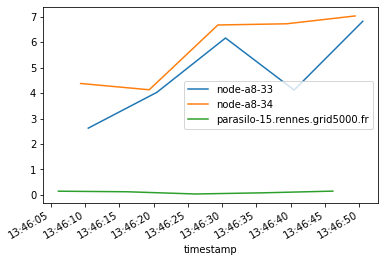

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

metric_df = MetricRangeDataFrame(metric_data)
metric_df.index = pd.to_datetime(metric_df.index, unit="s", utc=True)

df = metric_df[(metric_df["cpu"] == "cpu-total")]
df.value = pd.to_numeric(df.value)
fig, ax = plt.subplots()
for name, group in df.groupby('host'):
    group.plot(y='value', ax=ax, label=name)
plt.show()

## Deploying some apps

Copying app to nodes and installing dependencies.
A8 nodes have python 3.5 which requires specific version of numpy and aiocoap.

In [22]:
with play_on(pattern_hosts="%s" % iotlab_roles["a8"][0].address, roles=iotlab_roles) as p:
    p.shell("pip3 install aiocoap[all]==0.3")
    p.copy(src="burn.py", dest="burn.py", mode='0777')
    
with play_on(pattern_hosts="%s:compute" % iotlab_roles["a8"][0].address, roles=g5k_roles) as p:
    p.shell("pip3 install aiocoap[all]")
    p.copy(src="burn.py", dest="burn.py", mode='0777')

[    INFO] : Running playbook /home/donassolo/cs2/enoslib_tests/simple_example/tmpqw0s7l69 with vars:
{}

PLAY [node-a8-33.grenoble.iot-lab.info] ****************************************

TASK [Gathering Facts] *********************************************************
ok: [node-a8-33.grenoble.iot-lab.info]

PLAY [node-a8-33.grenoble.iot-lab.info] ****************************************

TASK [pip3 install aiocoap[all]==0.3] ******************************************
changed: [node-a8-33.grenoble.iot-lab.info]

TASK [__calling__ copy] ********************************************************
changed: [node-a8-33.grenoble.iot-lab.info]

PLAY RECAP *********************************************************************
node-a8-33.grenoble.iot-lab.info : ok=3    changed=2    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   

{'code': 0, 'result': [{'node-a8-33.grenoble.iot-lab.info': {'ok': 3, 'failures': 0, 'unreachable': 0, 'changed': 2, 'skipped': 0, 'rescued': 0, 'ignor

List IPv6 addresses of sensors

In [15]:
sensors_ipv6 = [iotlab_ipv6_net+sensor.uid for sensor in iotlab_roles["sensor"]]
print(sensors_ipv6)

['2001:660:5307:314e::b683']


Checking connectivity

In [16]:
with play_on(pattern_hosts="a8:compute", roles={**iotlab_roles, **g5k_roles}) as p:
    p.shell("ping6 -c3 %s" % sensors_ipv6[0])

[    INFO] : Running playbook /home/donassolo/cs2/enoslib_tests/simple_example/tmpkl3p17xs with vars:
{}

PLAY [a8:compute] **************************************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-15.rennes.grid5000.fr]
ok: [node-a8-33.grenoble.iot-lab.info]
ok: [node-a8-34.grenoble.iot-lab.info]

PLAY [a8:compute] **************************************************************

TASK [ping6 -c3 2001:660:5307:314e::b683] **************************************
changed: [parasilo-15.rennes.grid5000.fr]
changed: [node-a8-34.grenoble.iot-lab.info]
changed: [node-a8-33.grenoble.iot-lab.info]

PLAY RECAP *********************************************************************
node-a8-33.grenoble.iot-lab.info : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
node-a8-34.grenoble.iot-lab.info : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignor

Run burn on nodes

In [23]:
with play_on(pattern_hosts="a8:compute", roles={**iotlab_roles, **g5k_roles}) as p:
    p.shell("python3 burn.py --sensor %s --matrix 50" % sensors_ipv6[0], asynch=3600, poll=0)

[    INFO] : Running playbook /home/donassolo/cs2/enoslib_tests/simple_example/tmp81oc0k9u with vars:
{}

PLAY [a8:compute] **************************************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-15.rennes.grid5000.fr]
ok: [node-a8-33.grenoble.iot-lab.info]
ok: [node-a8-34.grenoble.iot-lab.info]

PLAY [a8:compute] **************************************************************

TASK [python3 burn.py --sensor 2001:660:5307:314e::b683 --matrix 50] ***********
changed: [parasilo-15.rennes.grid5000.fr]
changed: [node-a8-34.grenoble.iot-lab.info]
changed: [node-a8-33.grenoble.iot-lab.info]

PLAY RECAP *********************************************************************
node-a8-33.grenoble.iot-lab.info : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
node-a8-34.grenoble.iot-lab.info : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignor

Wait some time and see the effect on CPU utilization

In [28]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
import datetime as dt

metric_data = None

with G5kTunnel(g5k_roles["control"][0].address, 9090) as (local_addr,local_port,tunnel):
    url = "http://%s:%d" % (local_addr, local_port)
    prom = PrometheusConnect(url=url, disable_ssl=True)
    metric_data = prom.get_metric_range_data(
        metric_name="cpu_usage_user",
        start_time=dt.datetime.now() - dt.timedelta(minutes=30),
        end_time=dt.datetime.now(),
        chunk_size=dt.timedelta(minutes=1)
    )

[    INFO] : Connected (version 2.0, client OpenSSH_7.4p1)
[    INFO] : Authentication (publickey) successful!


[ WARNING] : /home/donassolo/enoslib_env/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value



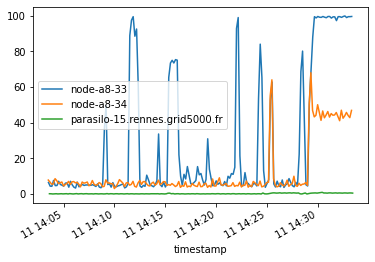

In [29]:
metric_df = MetricRangeDataFrame(metric_data)
metric_df.index = pd.to_datetime(metric_df.index, unit="s", utc=True)

df = metric_df[(metric_df["cpu"] == "cpu-total")]
df.value = pd.to_numeric(df.value)
fig, ax = plt.subplots()
for name, group in df.groupby('host'):
    group.plot(y='value', ax=ax, label=name)
plt.show()

## Cleanup

Stop monitoring

In [30]:
monitoring.backup()
monitoring.destroy()

[    INFO] : Running playbook /home/donassolo/enoslib/enoslib/service/monitoring/monitoring.yml with vars:
{'enos_action': 'backup', 'remote_working_dir': '/builds/monitoring', 'collector_address': '2001:660:4406:700:2::e', 'collector_port': 9090, 'backup_dir': '/home/donassolo/cs2/enoslib_tests/simple_example', 'ansible_python_interpreter': '/usr/bin/python3'}

PLAY [Gather facts] ************************************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-14.rennes.grid5000.fr]

TASK [Gather facts on all hosts] ***********************************************
ok: [parasilo-14.rennes.grid5000.fr]


[WARNING]: Could not match supplied host pattern, ignoring: telegraf



PLAY [Monitoring - Telegraf agents] ********************************************
skipping: no hosts matched

PLAY [Monitoring - InfluxDB collector] *****************************************
skipping: no hosts matched

PLAY [Monitoring - Prometheus collector] ***************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-14.rennes.grid5000.fr]

TASK [Install python3] *********************************************************
changed: [parasilo-14.rennes.grid5000.fr]

TASK [Install docker] **********************************************************
changed: [parasilo-14.rennes.grid5000.fr]

TASK [Installing python-docker] ************************************************
ok: [parasilo-14.rennes.grid5000.fr]

TASK [prometheus : include] ****************************************************
included: /home/donassolo/enoslib/enoslib/service/monitoring/roles/prometheus/tasks/backup.yml for parasilo-14.rennes.grid5000.fr

T

[WARNING]: Could not match supplied host pattern, ignoring: grafana



PLAY [Monitoring - Grafana UI] *************************************************
skipping: no hosts matched

PLAY RECAP *********************************************************************
parasilo-14.rennes.grid5000.fr : ok=11   changed=4    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   

{'code': 0, 'result': [{'parasilo-14.rennes.grid5000.fr': {'ok': 11, 'failures': 0, 'unreachable': 0, 'changed': 4, 'skipped': 0, 'rescued': 0, 'ignored': 0}}], 'playbook': '/home/donassolo/enoslib/enoslib/service/monitoring/monitoring.yml'}
[    INFO] : Running playbook /home/donassolo/enoslib/enoslib/service/monitoring/monitoring.yml with vars:
{'enos_action': 'destroy', 'remote_working_dir': '/builds/monitoring', 'ansible_python_interpreter': '/usr/bin/python3'}

PLAY [Gather facts] ************************************************************

TASK [Gathering Facts] *********************************************************
ok: [parasilo-14.rennes.grid5000.fr]
ok: [parasilo-1

Stop tunslip on frontend

In [31]:
result = run_command('pgrep -u "$(whoami)" tunslip6 | xargs kill', roles=frontend_roles)

None

PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
 [started TASK: Gathering Facts on grenoble]
ok: [grenoble]

TASK [enoslib_adhoc_command] ***************************************************
 [started TASK: enoslib_adhoc_command on grenoble]


fatal: [grenoble]: FAILED! => {"changed": true, "cmd": "pgrep -u \"$(whoami)\" tunslip6 | xargs kill", "delta": "0:00:00.034879", "end": "2021-02-11 15:45:10.099438", "msg": "non-zero return code", "rc": 123, "start": "2021-02-11 15:45:10.064559", "stderr": "\nUsage:\n kill [options] <pid> [...]\n\nOptions:\n <pid> [...]            send signal to every <pid> listed\n -<signal>, -s, --signal <signal>\n                        specify the <signal> to be sent\n -l, --list=[<signal>]  list all signal names, or convert one to a name\n -L, --table            list all signal names in a nice table\n\n -h, --help     display this help and exit\n -V, --version  output version information and exit\n\nFor more details see kill(1).", "stderr_lines": ["", "Usage:", " kill [options] <pid> [...]", "", "Options:", " <pid> [...]            send signal to every <pid> listed", " -<signal>, -s, --signal <signal>", "                        specify the <signal> to be sent", " -l, --list=[<signal>]  list all s

[   ERROR] : Failed hosts: [_AnsibleExecutionRecord(host='grenoble', status='FAILED', task='enoslib_adhoc_command', payload={'changed': True, 'end': '2021-02-11 15:45:10.099438', 'stdout': '', 'cmd': 'pgrep -u "$(whoami)" tunslip6 | xargs kill', 'delta': '0:00:00.034879', 'stderr': '\nUsage:\n kill [options] <pid> [...]\n\nOptions:\n <pid> [...]            send signal to every <pid> listed\n -<signal>, -s, --signal <signal>\n                        specify the <signal> to be sent\n -l, --list=[<signal>]  list all signal names, or convert one to a name\n -L, --table            list all signal names in a nice table\n\n -h, --help     display this help and exit\n -V, --version  output version information and exit\n\nFor more details see kill(1).', 'rc': 123, 'invocation': {'module_args': {'creates': None, 'executable': None, '_uses_shell': True, 'strip_empty_ends': True, '_raw_params': 'pgrep -u "$(whoami)" tunslip6 | xargs kill', 'removes': None, 'argv': None, 'warn': True, 'chdir': None

EnosFailedHostsError: [_AnsibleExecutionRecord(host='grenoble', status='FAILED', task='enoslib_adhoc_command', payload={'changed': True, 'end': '2021-02-11 15:45:10.099438', 'stdout': '', 'cmd': 'pgrep -u "$(whoami)" tunslip6 | xargs kill', 'delta': '0:00:00.034879', 'stderr': '\nUsage:\n kill [options] <pid> [...]\n\nOptions:\n <pid> [...]            send signal to every <pid> listed\n -<signal>, -s, --signal <signal>\n                        specify the <signal> to be sent\n -l, --list=[<signal>]  list all signal names, or convert one to a name\n -L, --table            list all signal names in a nice table\n\n -h, --help     display this help and exit\n -V, --version  output version information and exit\n\nFor more details see kill(1).', 'rc': 123, 'invocation': {'module_args': {'creates': None, 'executable': None, '_uses_shell': True, 'strip_empty_ends': True, '_raw_params': 'pgrep -u "$(whoami)" tunslip6 | xargs kill', 'removes': None, 'argv': None, 'warn': True, 'chdir': None, 'stdin_add_newline': True, 'stdin': None}}, 'start': '2021-02-11 15:45:10.064559', 'msg': 'non-zero return code', 'stdout_lines': [], 'stderr_lines': ['', 'Usage:', ' kill [options] <pid> [...]', '', 'Options:', ' <pid> [...]            send signal to every <pid> listed', ' -<signal>, -s, --signal <signal>', '                        specify the <signal> to be sent', ' -l, --list=[<signal>]  list all signal names, or convert one to a name', ' -L, --table            list all signal names in a nice table', '', ' -h, --help     display this help and exit', ' -V, --version  output version information and exit', '', 'For more details see kill(1).'], '_ansible_no_log': False})]

Destroy providers, free resources in testbeds

In [32]:
iotlab_provider.destroy()
g5k_provider.destroy()

[    INFO] : Stopping experiment id (246803)
[    INFO] : Reloading EnOSlib from grenoble
[    INFO] : Reloading EnOSlib from lille
[    INFO] : Reloading EnOSlib from luxembourg
[    INFO] : Reloading EnOSlib from lyon
[    INFO] : Reloading EnOSlib from nancy
[    INFO] : Reloading EnOSlib from nantes
[    INFO] : Reloading EnOSlib from rennes
[    INFO] : Reloading 1430467 from rennes
[    INFO] : Reloading EnOSlib from sophia
[    INFO] : Killing the job (rennes, 1430467)
